In [ ]:
import json
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
import pandas as pd
from collections import Counter
import torch.optim as optim
import spacy
import json
import re
import spacy
from tqdm import tqdm
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [ ]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
punctuation = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

def func_preprocess(text):
    text = text.lower()
    tokens = []
    text = text.replace('\n', ' ')
    text = re.sub(r'[^\x00-\x7F]+', '', text)  
    doc = nlp(text)
    for token in doc:
        if token.text not in punctuation and token.text not in stop_words and not token.text.isspace():
            tokens.append(token.text)
    return ' '.join(tokens)

In [ ]:

def main_preproces_func(data_path, k=1):
    message_list = []
    data = []
    with open(data_path, 'r') as file:
        for line in file:
            parsed_line = json.loads(line)
            data.append(parsed_line)
    label_list = []
    for i in tqdm(data):
        messages = i["messages"]
        labels = i["sender_labels"]
        for i in range(len(messages)):
            label_2 = str(labels[i]).strip().lower()
            if label_2 == "true":
                label = 1
            elif label_2 == "false":
                label = 0
            else:
                continue
            message_list.append(func_preprocess(messages[i]))
            label_list.append(label)
    return message_list, label_list
train_texts, train_labels = main_preproces_func("train.jsonl")
val_texts, val_labels = main_preproces_func("validation.jsonl")


100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


In [ ]:

nlp = spacy.load("en_core_web_sm")

def func_vocab(corpus, min_freq=1):
    tok_c = {}
    vocab = {}
    words = []
    index = 2
    for doc in nlp.pipe(corpus):
        for tok in doc:
            if not tok.is_punct and not tok.is_space:
                word = tok.text.lower()
                tok_c[word] = tok_c.get(word, 0) + 1
    for word, c in tok_c.items():
        if c >= min_freq:
            words.append(word)
    words.sort()
    for word in words:
        vocab[word] = index
        index += 1
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

In [ ]:
def token_func(text, vocabulary):
    doc = nlp(text)
    token_id = []
    for token in doc:
        if not token.is_punct and not token.is_space:
            word = token.text.lower()
            token = vocabulary.get(word, vocabulary['<UNK>'])
            token_id.append(token)
    return token_id

In [ ]:
def process_data(corpus, labels, vocab):
    toks = []
    for txt in corpus:
        ids = token_func(txt, vocab)
        t = torch.tensor(ids)
        toks.append(t)
    padded = pad_sequence(toks, batch_first=True, padding_value=vocab['<PAD>'])
    lbls = torch.tensor(labels, dtype=torch.long)
    return padded, lbls

In [ ]:

vocabulary = func_vocab(train_texts)

train_inputs, train_labels_tensor = process_data(train_texts, train_labels, vocabulary)
val_inputs, val_labels_tensor = process_data(val_texts, val_labels, vocabulary)

In [ ]:

class DataClass(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]



In [ ]:
train_df = DataClass(train_inputs, train_labels_tensor)
val_df = DataClass(val_inputs, val_labels_tensor)
train_loader = DataLoader(train_df, batch_size=32, shuffle=True)
val_loader = DataLoader(val_df, batch_size=32)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, output_dim=2, 
                 num_layers=1, bidirectional=False, dropout=0.3, pad_idx=0):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=bidirectional, batch_first=True)
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(lstm_output_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))  
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), 
                                                            batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1))
        else:
            hidden = self.dropout(hidden[-1])
        
        return self.fc(hidden) 

In [ ]:
def device_func():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def class_weight_func(labels):
    label_dist = Counter(labels)
    num_class = 2
    total_c = sum(label_dist.values())
    class_weights = [
        total_c / (num_class * label_dist[0]),  
        total_c/ (num_class * label_dist[1])  
    ]
    return torch.tensor(class_weights, dtype=torch.float)

In [ ]:

def initialize_model(vocab_size, class_weights, device):
    model = LSTM(vocab_size=vocab_size, bidirectional=True).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return model, criterion, optimizer

In [ ]:
def process_batch(model, batch_inputs, batch_labels, criterion, optimizer, device, vocab):
    # Move inputs and labels to the specified device (CPU/GPU)
    batch_inputs = batch_inputs.to(device)
    batch_labels = batch_labels.to(device)

    # Clear previous gradients
    optimizer.zero_grad()
    seq_lens = torch.sum(batch_inputs != vocab['<PAD>'], dim=1)

    # Filter out sequences with zero length
    valid_mask = seq_lens > 0
    batch_inputs = batch_inputs[valid_mask]
    batch_labels = batch_labels[valid_mask]
    seq_lens = seq_lens[valid_mask]
    # if len(batch_inputs) == 0:
    #     return 0.0  
    logits = model(batch_inputs, seq_lens)
    loss = criterion(logits, batch_labels)
    loss.backward()
    optimizer.step()
    return loss.item()


In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device, vocabulary):
    model.train()
    total_loss = 0
    for batch_inputs, batch_labels in train_loader:
        loss = process_batch(model, batch_inputs, batch_labels, criterion, optimizer, device, vocabulary)
        total_loss += loss
    return total_loss / len(train_loader)

In [ ]:
def batch_func(model, x, y, crit, device, vocab):
    x = x.to(device)
    y = y.to(device)
    seq_length = torch.sum(x != vocab['<PAD>'], dim=1)
    valid = seq_length > 0
    x = x[valid]
    y = y[valid]
    seq_length = seq_length[valid]
    # if len(x) == 0:
    #     return 0.0
    logits = model(x, seq_length)
    loss = crit(logits, y)
    return loss.item()
def evaluate_epoch(model, loader, crit, device, vocab):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, j in loader:
            loss = batch_func(model, i, j, crit, device, vocab)
            total_loss += loss
    return total_loss / len(loader)


Epoch 1 - Training Loss: 0.6809 - Validation Loss: 0.6472
Epoch 2 - Training Loss: 0.6352 - Validation Loss: 0.6508
Epoch 3 - Training Loss: 0.5581 - Validation Loss: 0.7013
Epoch 4 - Training Loss: 0.4829 - Validation Loss: 0.7203
Epoch 5 - Training Loss: 0.4119 - Validation Loss: 0.7926
Epoch 6 - Training Loss: 0.3434 - Validation Loss: 0.8385
Epoch 7 - Training Loss: 0.2703 - Validation Loss: 1.0883
Epoch 8 - Training Loss: 0.2238 - Validation Loss: 1.2139
Epoch 9 - Training Loss: 0.2039 - Validation Loss: 1.3219
Epoch 10 - Training Loss: 0.1804 - Validation Loss: 1.3513
Epoch 11 - Training Loss: 0.1641 - Validation Loss: 1.3790
Epoch 12 - Training Loss: 0.1779 - Validation Loss: 1.2792
Epoch 13 - Training Loss: 0.1465 - Validation Loss: 1.3353
Epoch 14 - Training Loss: 0.1260 - Validation Loss: 1.4408
Epoch 15 - Training Loss: 0.1237 - Validation Loss: 1.5732


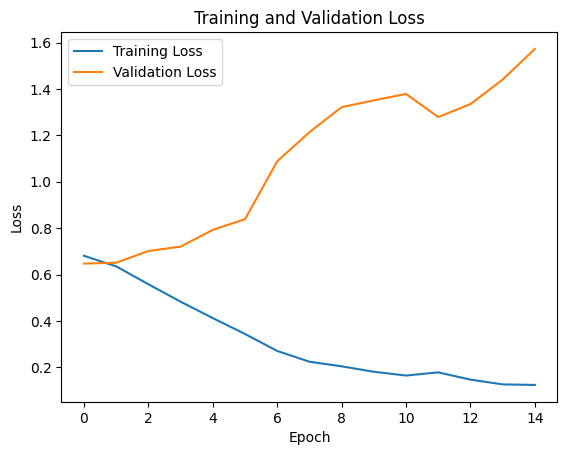

In [ ]:

train_losses = []
val_losses = []
def plot_losses(training_losses, validation_losses):
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

device = device_func()
class_weights = class_weight_func(train_labels)
model, criterion, optimizer = initialize_model(len(vocabulary), class_weights, device)

for epoch in range(15):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, vocabulary)
    val_loss = evaluate_epoch(model, val_loader, criterion, device, vocabulary)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

plot_losses(train_losses, val_losses)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
def eval_loop(m, loader, dev, vocab):
    m.eval()
    preds = []
    labels =[]
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(dev), y.to(dev)
            lens = torch.sum(x != vocab['<PAD>'], dim=1)
            mask = lens > 0
            x = x[mask]
            y = y[mask]
            lens = lens[mask]
            if len(x) == 0:
                continue
            out = m(x, lens)
            out = torch.argmax(out, dim=1)
            preds.extend(out.tolist())
            labels.extend(y.tolist())
    return preds, labels

In [ ]:
def evaluate(m, loader, dev, vocab):
    preds, labels = eval_loop(m, loader, dev, vocab)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    _, _, f1s, _ = precision_recall_fscore_support(labels, preds, average=None, labels=[0, 1])
    lie_f1 = f1s[0]

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Lie (Class 0) F1 Score: {lie_f1:.4f}")

    return acc, macro_f1, lie_f1

In [ ]:

torch.save(model.state_dict(), 'lstm_model_NBi_2.pth')


In [ ]:
test_texts, test_labels = main_preproces_func("test.jsonl", k=0)
test_inputs, test_labels_tensor = process_data(test_texts, test_labels, vocabulary)
test_ds = DataClass(test_inputs, test_labels_tensor)
test_loader = DataLoader(test_ds, batch_size=32)

  0%|          | 0/42 [00:00<?, ?it/s]

100%|██████████| 42/42 [00:18<00:00,  2.21it/s]


In [ ]:
print(" Evaluating on Test Set:")
evaluate(model, test_loader)

📊 Evaluating on Test Set:
Accuracy: 0.8333
Macro F1 Score: 0.5327
Lie (Class 0) F1 Score: 0.1579


(0.8332713062895423, 0.5326854931628948, 0.15789473684210525)

In [ ]:
#loading the model
# model1 = LSTM(vocab_size=len(vocabulary)).to(device)
model1 = LSTM(vocab_size=len(vocabulary), bidirectional=True).to(device)
model1.load_state_dict(torch.load('lstm_model_3.pth'))

evaluate(model1, test_loader)
evaluate(model1, val_loader)

Accuracy: 0.8489
Macro F1 Score: 0.5458
Lie (Class 0) F1 Score: 0.1748
Accuracy: 0.8799
Macro F1 Score: 0.5260
Lie (Class 0) F1 Score: 0.1164


(0.879942487419123, 0.52599897567117, 0.1164021164021164)